## Notebook to analyze biosynthetic pathways and reactions fluxes for secondary metabolites in EcN

In [88]:
import cobra
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cameo
from cameo.strain_design.deterministic.flux_variability_based import FSEOF
from cameo import phenotypic_phase_plane
from cameo.strain_design.deterministic import DifferentialFVA
from cameo.strain_design import OptGene
import numpy as np
from scipy.stats import linregress
from cameo.visualization.plotting.with_plotly import PlotlyPlotter

ModuleNotFoundError: No module named 'plotly'

In [3]:
# load model with sec mets
EcN_model = cobra.io.load_json_model('../data/models/CP022686.1_cur_4.7.json')
df_sec_met_rxn = pd.read_csv('../tables/sec_met_paths_reactions.csv', index_col='ID')
EcN_model.summary()
with EcN_model as model:
    pfba_solution_WT = cobra.flux_analysis.pfba(model)

In [4]:
target_exchange_dict = dict({'Yersiniabactin': 'EX_ybt_e', 
                   'Colibactin': 'EX_clbtn_e', 
                   'Enterobactin': 'EX_enter_e',
                   'Salmochelin': 'EX_salchsx_e',
                    'Aerobactin': 'EX_arbtn_e'})

pfba_matrix = pd.DataFrame(index=pfba_solution_WT.to_frame().index.tolist())
pfba_matrix['fluxes:WT'] = pfba_solution_WT.to_frame()['fluxes']

for sec_met in target_exchange_dict.keys():
    target_exchange = target_exchange_dict[sec_met] 
    with EcN_model as model:
        model.objective = target_exchange
        pfba_solution_tgt = cobra.flux_analysis.pfba(model)
        print('Maximum flux through', target_exchange, pfba_solution_tgt[target_exchange])
        pfba_matrix['fluxes:' + sec_met] = pfba_solution_tgt.to_frame().loc[pfba_matrix.index,'fluxes']

Maximum flux through EX_ybt_e 1.9833035569270723
Maximum flux through EX_clbtn_e 1.0111711711711713
Maximum flux through EX_enter_e 3.0581974248927004
Maximum flux through EX_salchsx_e 5.764758645107987
Maximum flux through EX_arbtn_e 4.513220338983045


In [5]:
p = phenotypic_phase_plane(EcN_model, variables=['BIOMASS_Ec_iML1515_core_75p37M'], objective='EX_enter_e')
df_sec_met_all = p.data_frame.reindex(columns = ['BIOMASS_Ec_iML1515_core_75p37M'])

for sec_met in target_exchange_dict.keys():
    target_exchange = target_exchange_dict[sec_met] 
    with EcN_model as model:
        model.objective = target_exchange
        p_sec_met = phenotypic_phase_plane(EcN_model, variables=['BIOMASS_Ec_iML1515_core_75p37M'], objective=target_exchange)
        df_sec_met = p_sec_met.data_frame.copy()
        df_sec_met_all[target_exchange] = df_sec_met['objective_upper_bound']

df_sec_met_all.set_index('BIOMASS_Ec_iML1515_core_75p37M', inplace=True)

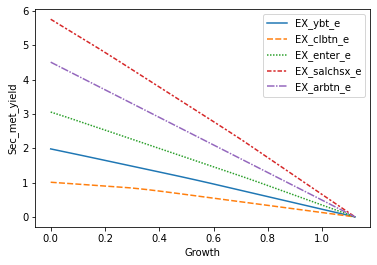

In [6]:
plt.figure()
ax = sns.lineplot(data=df_sec_met_all)
plt.xlabel('Growth')
plt.ylabel('Sec_met_yield')
plt.show()

## FSEOF

In [7]:
fseof = FSEOF(EcN_model)

In [10]:
df_fseof_tgt_slopes = pd.DataFrame(columns=target_exchange_dict.keys())

ignore_rxn = df_sec_met_rxn.index.tolist()
ignore_rxn = ignore_rxn + ['H2Otpp', 'CO2tex', 'CO2tpp', 'H2Otex']

for sec_met in target_exchange_dict.keys():
    target_exchange = target_exchange_dict[sec_met] 
    results_tgt = fseof.run(target=target_exchange)
    df_fseof_tgt = results_tgt.data_frame
    
    for row in df_fseof_tgt.index:
        if row not in ignore_rxn:
            flux_range = df_fseof_tgt.loc[row,:]
            linreg = linregress(df_fseof_tgt.loc[target_exchange,:], flux_range)
            slope = linreg.slope
            df_fseof_tgt_slopes.loc[row, sec_met] = slope

In [62]:
df_fseof_tgt_slopes

,Yersiniabactin,Colibactin,Enterobactin,Salmochelin,Aerobactin
GTHOr,2.860925,3.752339,-0.090871,-0.047994,-0.061485
PFK_3,1.364619,NaN,0.047444,0.534447,NaN
SHK3Dr,0.785827,NaN,2.86006,0.92609,NaN
HCO3E,0.70462,5.473994,NaN,NaN,NaN
PPA,8.046965,14.522082,4.723897,3.326016,1.13656
...,...,...,...,...,...
DHDPS,NaN,NaN,NaN,NaN,1.90784
ACt4pp,NaN,NaN,NaN,NaN,-0.001293
NH4tex,NaN,NaN,NaN,NaN,1.316832
THDPS,NaN,NaN,NaN,NaN,1.90784


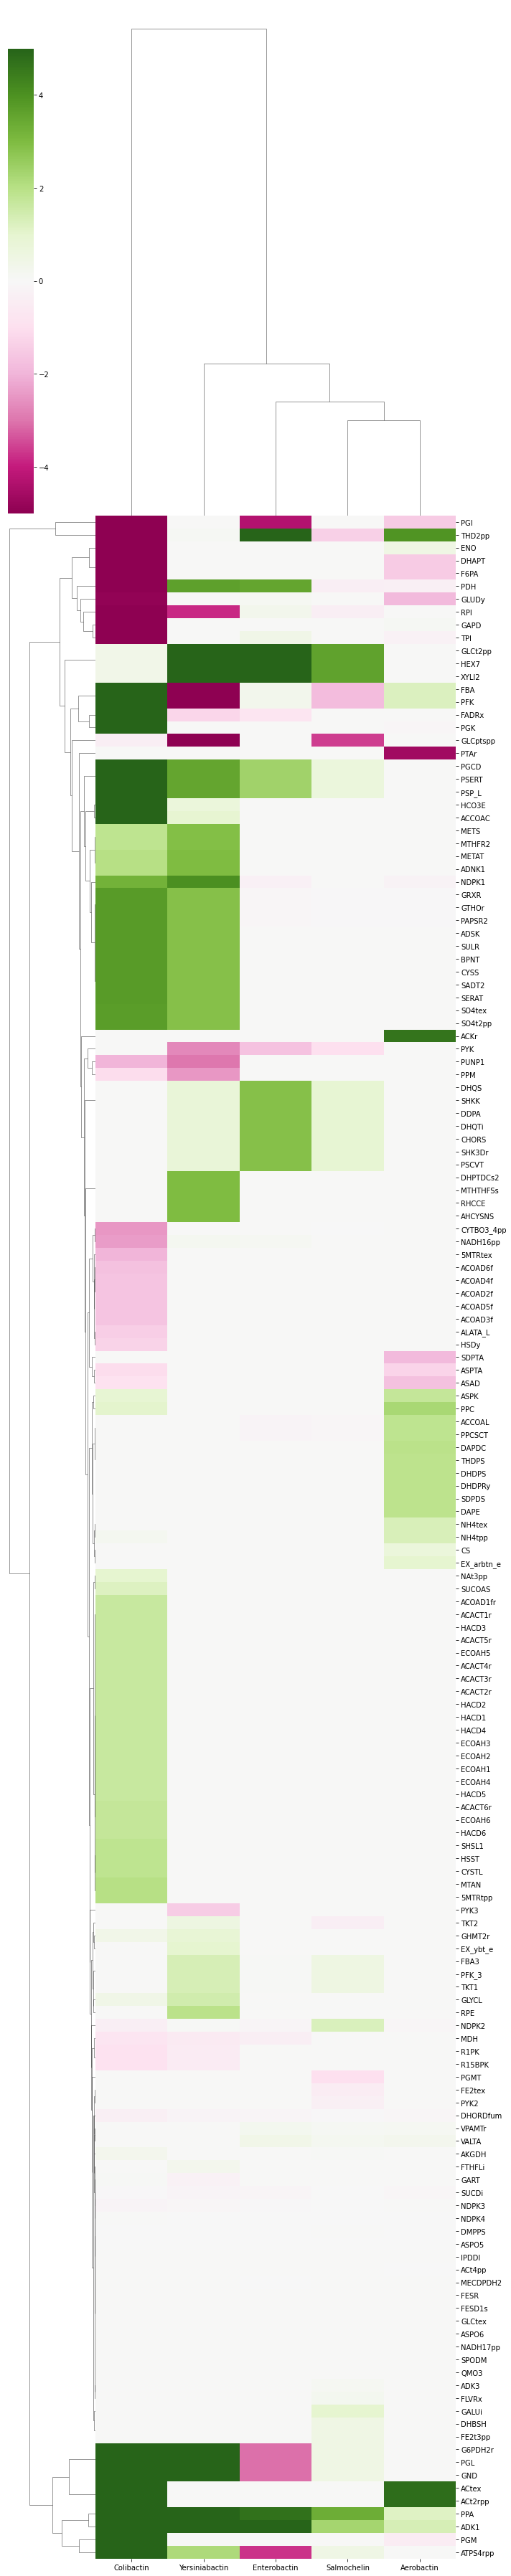

In [82]:
sns.clustermap(df_fseof_tgt_slopes.fillna(0).sort_values(by=df_fseof_tgt_slopes.columns.tolist()), cmap='PiYG', 
              center=0, row_cluster=True, col_cluster=True, figsize=(10,50), vmin=-5, vmax=5)

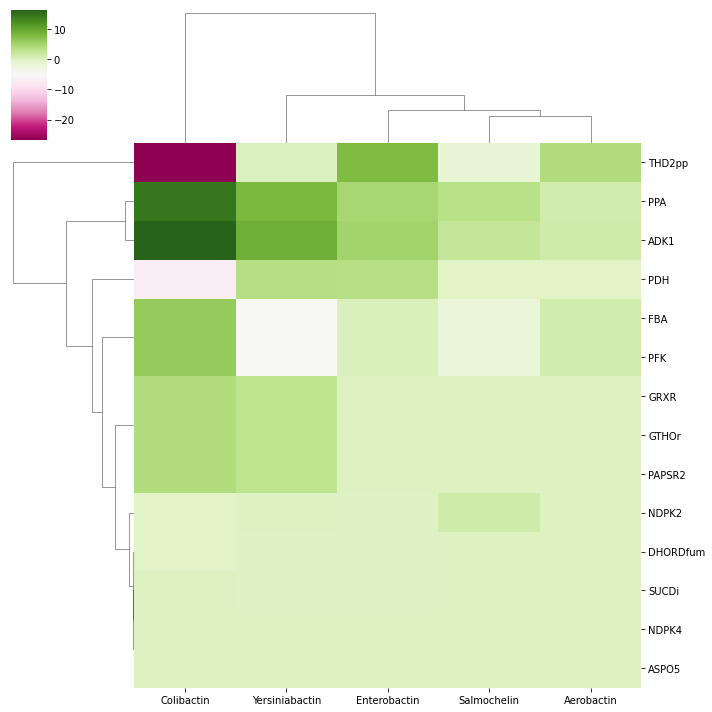

In [66]:
df_fseof_tgt_slopes_common = df_fseof_tgt_slopes.dropna(how='any')
df_fseof_tgt_slopes_common

In [14]:
results = fseof.run(target='EX_ybt_e')
df_fseof_tgt = results.data_frame
df_fseof_tgt

,1,2,3,4,5,6,7,8,9,10
GTHOr,0.788993,1.300489,1.811985,2.323481,2.834977,3.346205,3.856261,4.365695,4.875128,5.384498
PFK_3,2.362120,2.659574,2.957028,3.254482,3.551936,3.323065,4.096570,4.238501,4.380433,4.522127
SHK3Dr,0.568885,0.710428,0.851972,0.993516,1.135060,1.276192,1.415518,1.553885,1.692252,1.830523
HCO3E,0.716904,0.844436,0.971969,1.099501,1.227033,1.353999,1.478472,1.601623,1.724775,1.847793
PPA,5.344889,6.792885,8.240880,9.688876,11.136872,12.581117,14.008889,15.427917,16.846946,18.265094
...,...,...,...,...,...,...,...,...,...,...
YBTS17,0.178497,0.356995,0.535492,0.713989,0.892487,1.070984,1.249482,1.427979,1.606476,1.784974
YBTS18,0.178497,0.356995,0.535492,0.713989,0.892487,1.070984,1.249482,1.427979,1.606476,1.784974
YBTtpp,0.178497,0.356995,0.535492,0.713989,0.892487,1.070984,1.249482,1.427979,1.606476,1.784974
YBTtex,0.178497,0.356995,0.535492,0.713989,0.892487,1.070984,1.249482,1.427979,1.606476,1.784974


In [87]:
reference_model = EcN_model.copy()
biomass_rxn = reference_model.reactions.BIOMASS_Ec_iML1515_core_75p37M
biomass_rxn.lower_bound = 0.
target = reference_model.metabolites.succ_e
plotter = PlotlyPlotter()

NameError: name 'PlotlyPlotter' is not defined

In [17]:
diffFVA = DifferentialFVA(design_space_model=EcN_model,
                          reference_model=reference_model,
                          objective=target,
                          variables=[biomass_rxn],
                          normalize_ranges_by=biomass_rxn,
                          points=10)

In [18]:
result = diffFVA.run()

HBox()

In [83]:
production_envelope = phenotypic_phase_plane(EcN_model,
                                             variables=[EcN_model.reactions.BIOMASS_Ec_iML1515_core_75p37M],
                                             objective=EcN_model.reactions.EX_succ_e)
production_envelope.plot(height=400)

TypeError: plot() missing 1 required positional argument: 'plotter'

In [ ]:
production_envelope = phenotypic_phase_plane(EcN_model,
                                             variables=[EcN_model.reactions.EX_enter_e],
                                             objective=EcN_model.reactions.FBA)
production_envelope.plot(height=400)

In [86]:
with EcN_model as model:
    model.objective = 'EX_ybt_e'
    fba_result = cameo.fba(model)
    max_ybt_flux_ref = fba_result.objective_value
    print('Ybt flux:', max_ybt_flux_ref)

fba_result_ref = cameo.fba(EcN_model)
max_bio_flux_ref = fba_result_ref.objective_value

with EcN_model as model:
    production_envelope = phenotypic_phase_plane(model,
                                        variables=[model.reactions.BIOMASS_Ec_iML1515_core_75p37M],
                                        objective=model.reactions.EX_ybt_e,
                                                      points=40)
   
    production_envelope.plot(plotter, title='Ybt vs Biomass flux phase plane- ', 
                             points=[(max_bio_flux_ref, 0), (0, max_ybt_flux_ref)], 
                             points_colors=["green", "red"])

Ybt flux: 1.9833035569270763


TypeError: plot() missing 1 required positional argument: 'plotter'

## PFBA matrix

In [23]:
pfba_matrix = pd.DataFrame(index=pfba_solution_WT.to_frame().index.tolist())
pfba_matrix['fluxes:WT'] = pfba_solution_WT.to_frame()['fluxes']

for sec_met in target_exchange_dict.keys():
    target_exchange = target_exchange_dict[sec_met] 
    print(pfba_solution_WT[target_exchange])
    with EcN_model as model:
        model.objective = target_exchange
        pfba_solution_tgt = cobra.flux_analysis.pfba(model)
        print('Flux through', target_exchange, pfba_solution_tgt[target_exchange])
        pfba_matrix['fluxes:' + sec_met] = pfba_solution_tgt.to_frame().loc[pfba_matrix.index,'fluxes']

0.0
Flux through EX_ybt_e 1.9833035569269937
0.0
Flux through EX_clbtn_e 1.0111711711711715
0.0
Flux through EX_enter_e 3.0581974248927026
0.0
Flux through EX_salchsx_e 5.764758645107988
0.0
Flux through EX_arbtn_e 4.51322033898305


### Variability in pfba_matrix

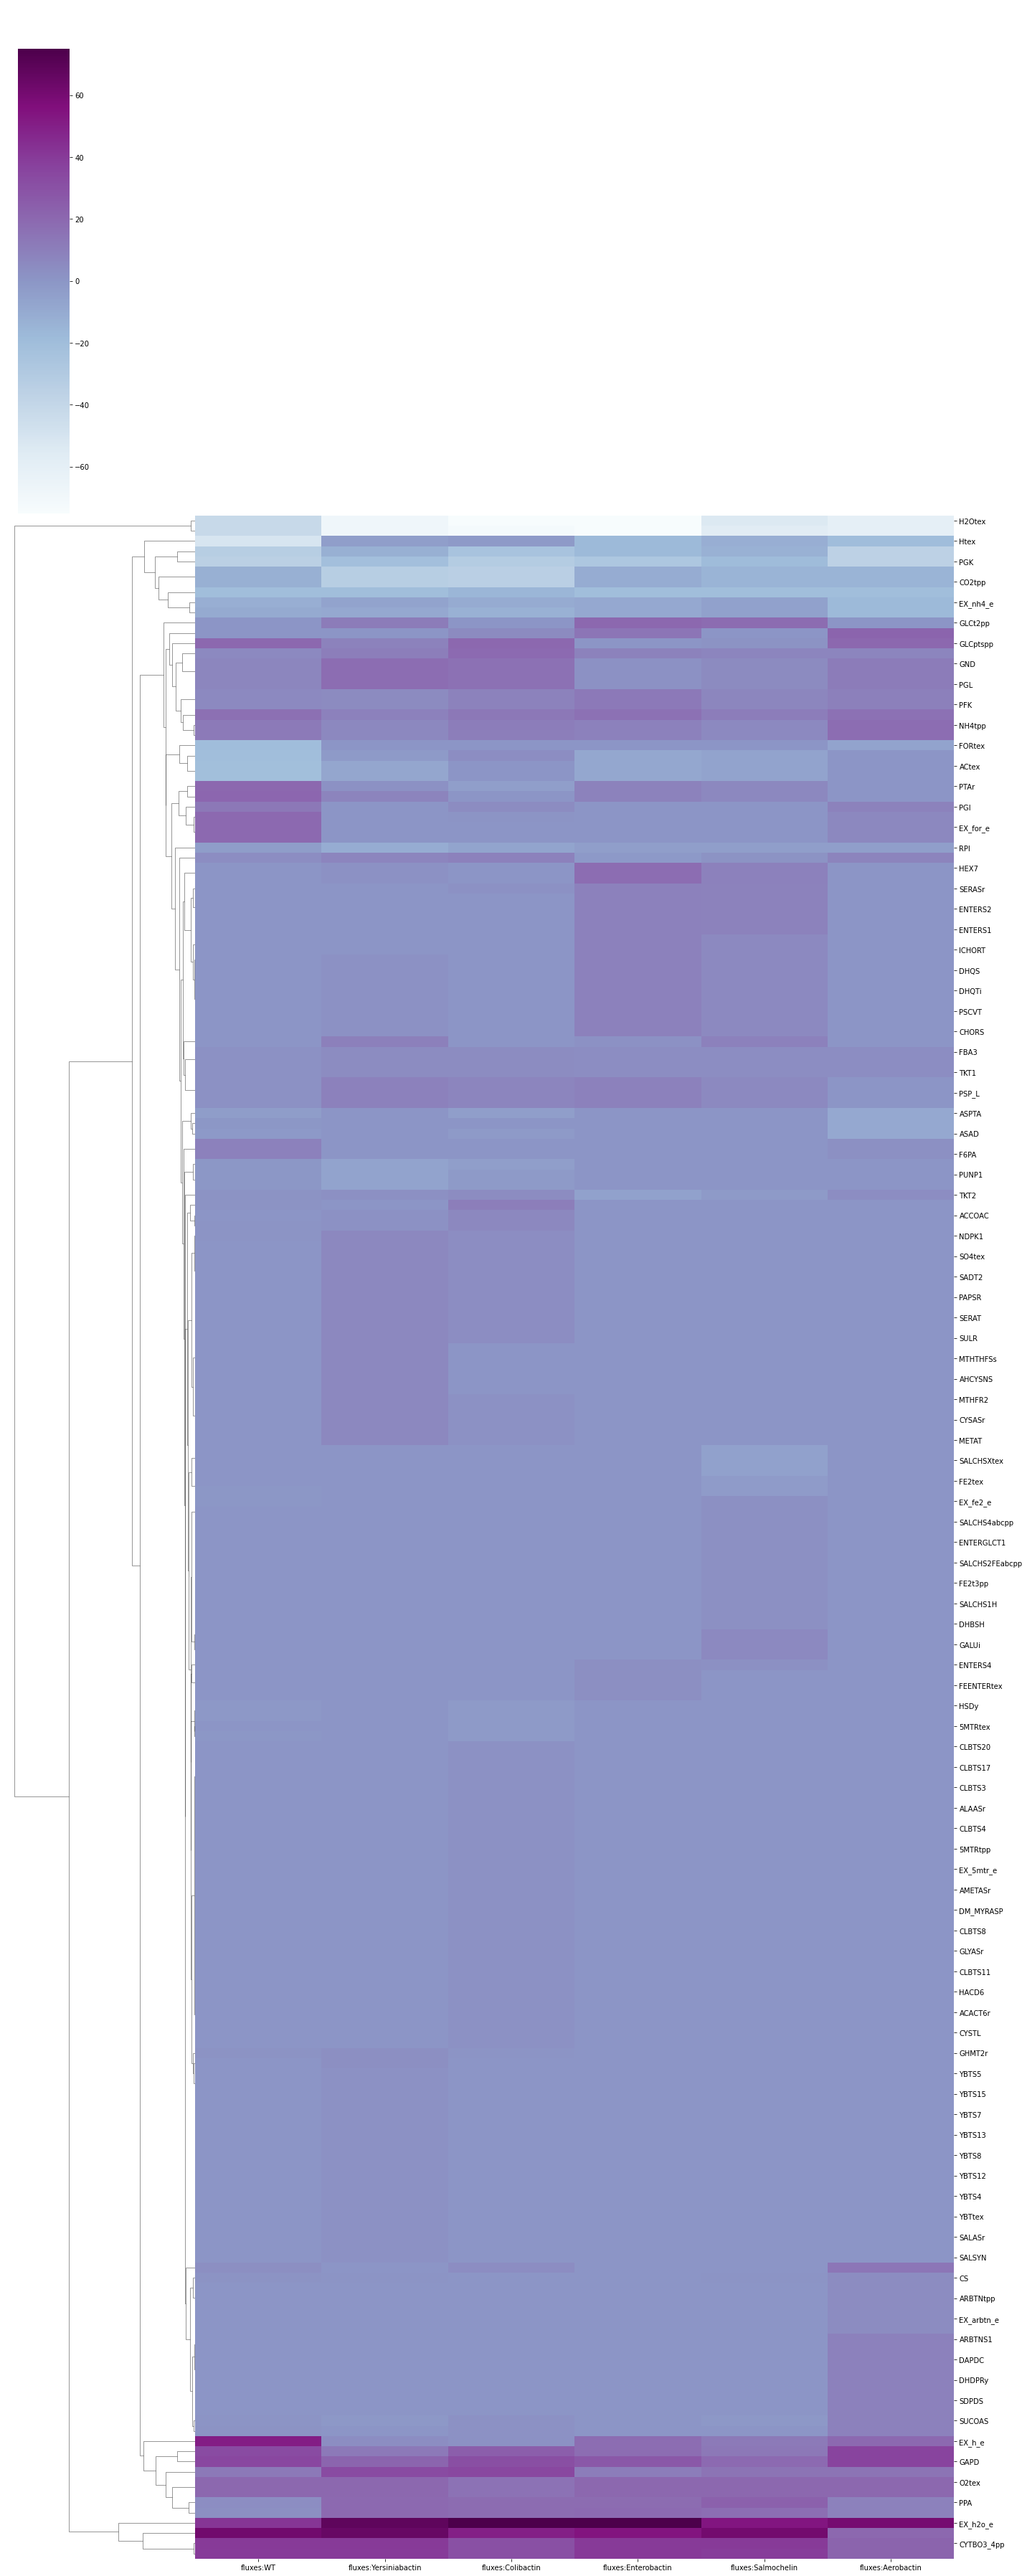

In [24]:
top_var_rxns = pfba_matrix.var(axis=1).sort_values(ascending=False).index.tolist()[:200]
pfba_matrix_top = pfba_matrix.loc[top_var_rxns, :]
sns.clustermap(pfba_matrix_top, cmap='BuPu', col_cluster=False, figsize=(20,50))

In [25]:
# Get all the reactions specifically contributing to sec met fluxes
# Combine all specific sec mets to get final heatmap
diff_sec_met = pfba_matrix['fluxes:Yersiniabactin'] - pfba_matrix['fluxes:WT']
diff_sec_met.sort_values()[-100:]

VALTA        0.474483
AIRC3        0.502102
IPPMIa       0.505171
IPPMIb       0.505171
GLUDy        0.602789
              ...    
FORtex      19.799812
EX_co2_e    20.396356
PGM         20.636430
EX_h2o_e    26.490292
Htex        47.062726
Length: 100, dtype: float64

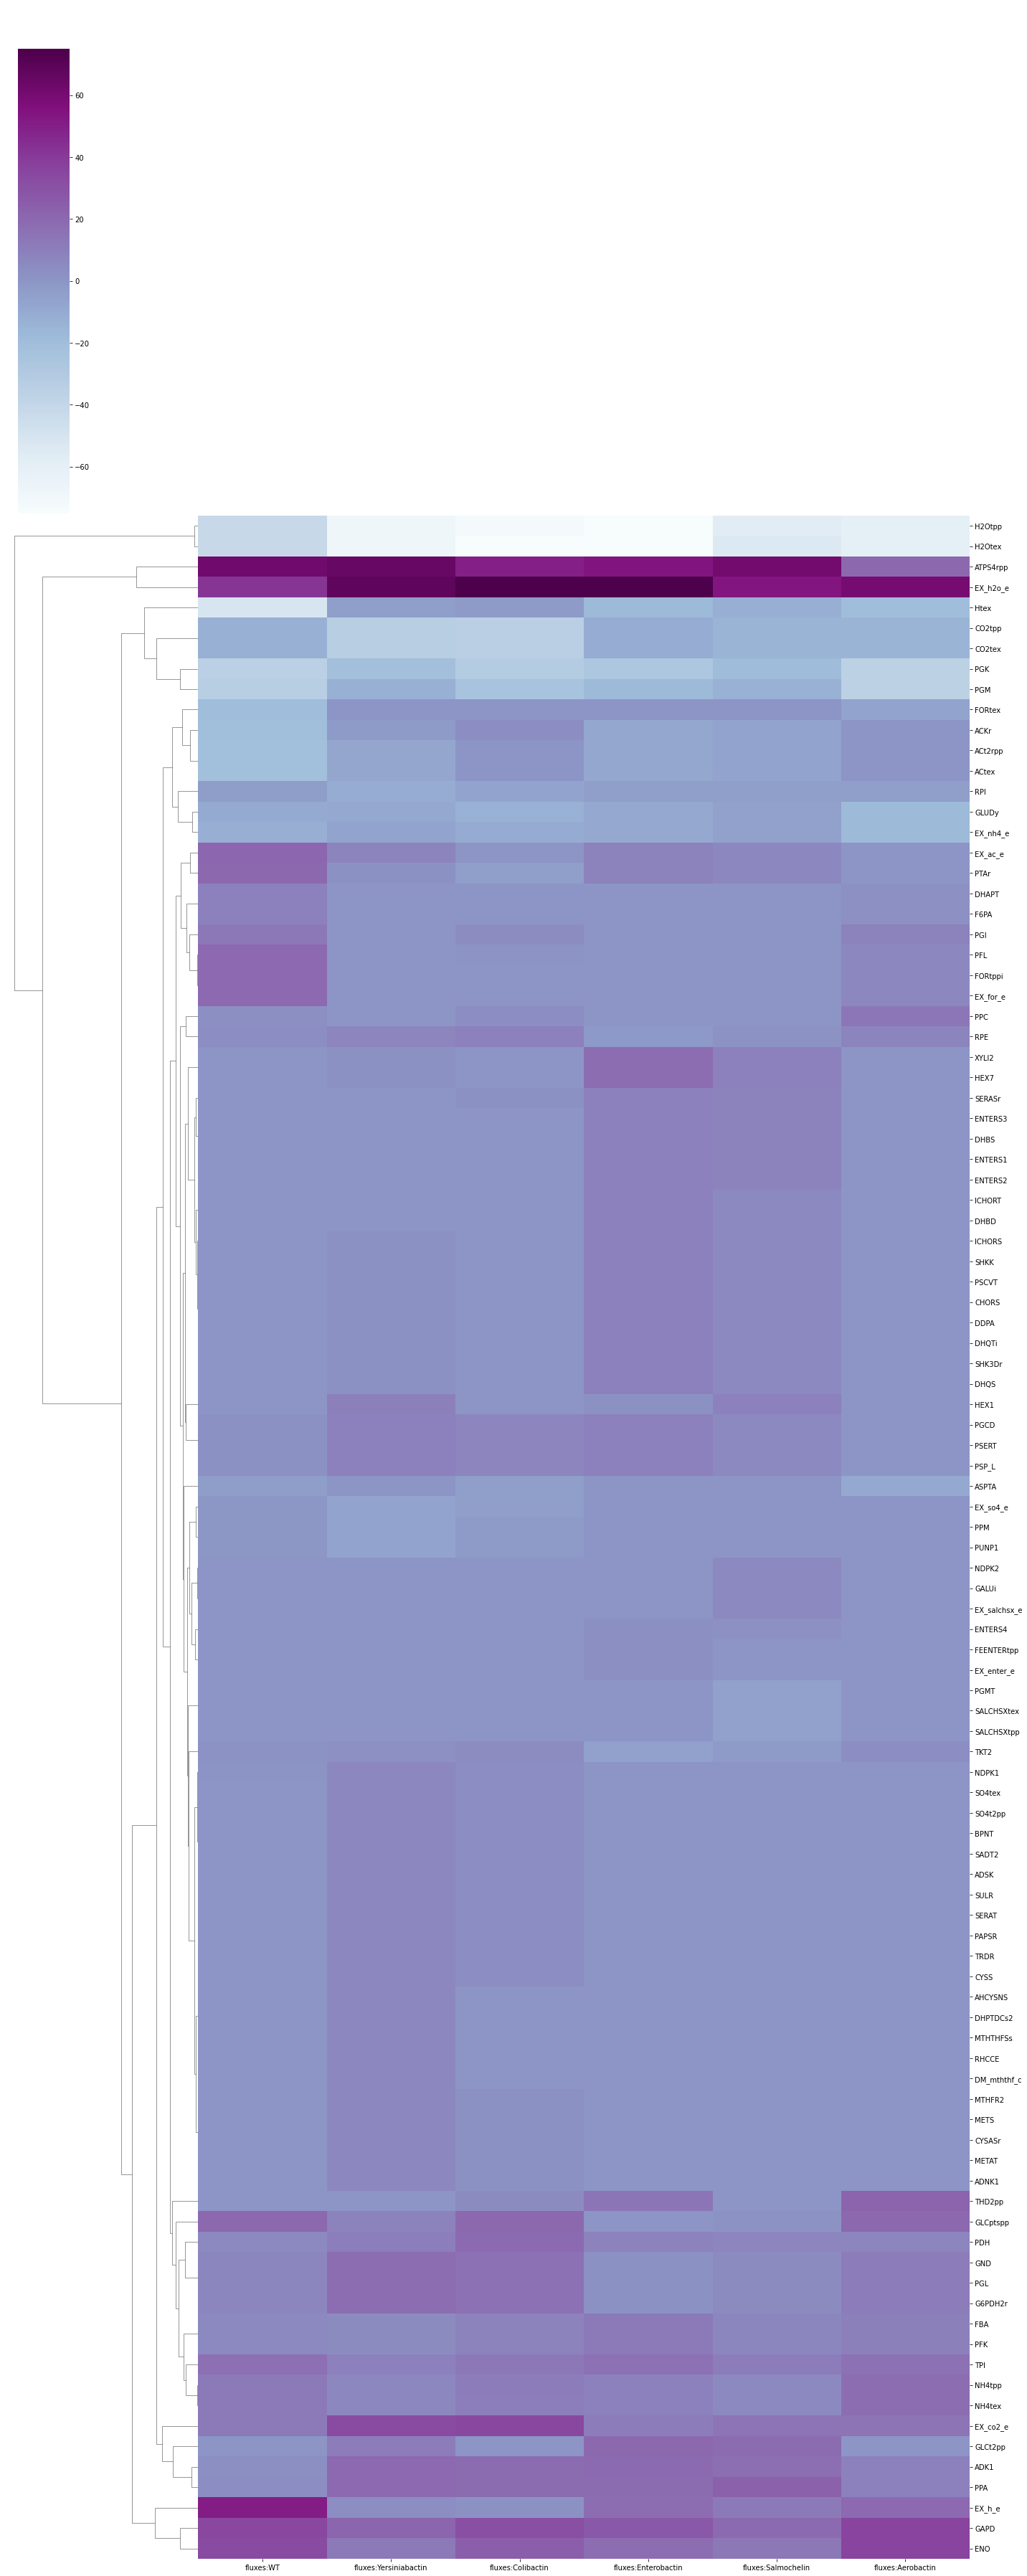

In [26]:
idx_selected = pfba_matrix.iloc[:,[0,1,3,4]].var(axis=1).sort_values()[-100:].index.tolist()
# top_var_rxns = pfba_matrix.var(axis=1).sort_values(ascending=False).index.tolist()[:200]
pfba_matrix_top = pfba_matrix.loc[idx_selected, :]
sns.clustermap(pfba_matrix_top, cmap='BuPu', col_cluster=False, figsize=(20,50))

In [27]:
# Remove CO2 H20, etc and Biosynthetic reactions

In [28]:
pfba_solution_tgt['BIOMASS_Ec_iML1515_core_75p37M']

0.0

## Reaction deletion matrix

In [29]:
rxn_deletion_wt = cobra.flux_analysis.single_reaction_deletion(EcN_model)

In [30]:
rxn_del_matrix = pd.DataFrame(index=rxn_deletion_wt.index.tolist())
rxn_del_matrix['growth:WT'] = rxn_deletion_wt['growth']

for sec_met in target_exchange_dict.keys():
    target_exchange = target_exchange_dict[sec_met] 
    with EcN_model as model:
        model.objective = target_exchange
        rxn_deletion_tgt = cobra.flux_analysis.single_reaction_deletion(model)
        rxn_del_matrix['flux:' + sec_met] = rxn_deletion_tgt.loc[rxn_del_matrix.index, 'growth']

In [31]:
rxn_del_matrix

,growth:WT,flux:Yersiniabactin,flux:Colibactin,flux:Enterobactin,flux:Salmochelin,flux:Aerobactin
0,1.121280e+00,1.983304,1.011171e+00,3.058197,5.764759e+00,4.51322
1,1.121156e+00,1.983304,1.011171e+00,3.058197,5.764759e+00,4.51322
2,1.121280e+00,1.983304,1.011171e+00,3.058197,5.764759e+00,4.51322
3,1.121280e+00,1.983304,1.011171e+00,3.058197,5.764759e+00,4.51322
4,1.121280e+00,1.983304,1.011171e+00,3.058197,5.764759e+00,4.51322
...,...,...,...,...,...,...
2940,1.121280e+00,1.983304,1.011171e+00,3.058197,-4.131931e-14,4.51322
2941,-3.632574e-11,1.983304,1.011171e+00,3.058197,5.764759e+00,4.51322
2942,1.121280e+00,1.983304,1.011171e+00,3.058197,5.764759e+00,4.51322
2943,1.121280e+00,1.983304,1.039797e-15,3.058197,5.764759e+00,4.51322


In [32]:
rxn_del_matrix.max(axis=0)

growth:WT              1.179054
flux:Yersiniabactin    2.072438
flux:Colibactin        1.024182
flux:Enterobactin      3.175966
flux:Salmochelin       6.023840
flux:Aerobactin        4.675325
dtype: float64

## Reaction essentiality matrix

Find reactions that are non-essential but are essential for production of secondary metabolites (if any)

## Optimize production by KO

Find reactions that are non-essential but are essential for production of secondary metabolites (if any)

In [ ]:
rxn_ess_matrix = rxn_del_matrix > 0.05
rxn_ess_matrix = rxn_ess_matrix * 1
# max_flux = rxn_del_matrix.max(axis=0) * 0.05
rxn_ess_matrix[rxn_ess_matrix.sum(1)<5]

## Double reaction knockout

In [ ]:
rxn_double_deletion_wt = cobra.flux_analysis.double_reaction_deletion(EcN_model)

## Gene deletion matrix

In [ ]:
gene_deletion_wt = cobra.flux_analysis.single_gene_deletion(EcN_model)

In [ ]:
gene_del_matrix = pd.DataFrame(index=gene_deletion_wt.index.tolist())
gene_del_matrix['growth:WT'] = gene_deletion_wt['growth']

for sec_met in target_exchange_dict.keys():
    target_exchange = target_exchange_dict[sec_met] 
    with EcN_model as model:
        model.objective = target_exchange
        gene_deletion_tgt = cobra.flux_analysis.single_gene_deletion(model)
        gene_del_matrix['flux:' + sec_met] = gene_deletion_tgt.loc[gene_del_matrix.index, 'growth']

In [ ]:
rxn_ess_matrix = gene_del_matrix > 0.05
rxn_ess_matrix = rxn_ess_matrix * 1
# max_flux = rxn_del_matrix.max(axis=0) * 0.05
rxn_ess_matrix[rxn_ess_matrix.sum(1)<5]

## Run OptGene

In [34]:
EcN_model = cobra.io.load_json_model('../data/models/CP022686.1_cur_4.7.json')
optgene = OptGene(EcN_model)

In [35]:
result = optgene.run(target=model.reactions.EX_ac_e, 
                     biomass=model.reactions.BIOMASS_Ec_iML1515_core_75p37M,
                     substrate=model.metabolites.glc__D_e,
                     max_evaluations=5000,
                     plot=False)

Starting optimization at Fri, 15 Oct 2021 12:02:08


HBox()

Finished after 00:10:15


In [36]:
result

HBox()

,reactions,genes,size,fva_min,fva_max,target_flux,biomass_flux,yield,fitness
0,"(THFAT, GHMT2r)","((CIW80_06560,),)",1,18.782553,25.255518,24.657506,1.096776,1.232875,1.352188
1,"(RPE,)","((CIW80_11440,),)",1,20.201119,23.396479,22.690828,1.121280,1.134541,1.272139
2,"(PMANM, MTHFD, MTHFC)","((CIW80_04030, CIW80_20780), (CIW80_20780, CIW...",2,18.712968,25.000829,24.400242,1.100890,1.220012,1.343099
3,"(OHPBAT, PSERT, RPE)","((CIW80_11440, CIW80_22550),)",2,22.564513,25.560342,25.078094,1.083337,1.253905,1.358401
4,"(MTHFD, UDPKAAT, MTHFC)","((CIW80_05210, CIW80_20780), (CIW80_20780, CIW...",2,18.712968,25.000829,24.400242,1.100890,1.220012,1.343099
5,"(MTHFD, RPE, MTHFC)","((CIW80_11440, CIW80_20780),)",2,20.512372,24.376499,23.973163,1.100890,1.198658,1.319591
6,"(MTHFD, PGL, MTHFC)","((CIW80_21825, CIW80_20780),)",2,21.094890,25.000829,24.400242,1.100890,1.220012,1.343099
7,"(MTHFD, DOGULNR, MTHFC)","((CIW80_12595, CIW80_20780),)",2,18.712968,25.000829,24.400242,1.100890,1.220012,1.343099
8,"(DDGLCNt2rpp, MTHFD, MTHFC)","((CIW80_14555, CIW80_20780),)",2,18.712968,25.000829,24.400242,1.100890,1.220012,1.343099
9,"(MTHFD, AGMPTRCtpp, MTHFC)","((CIW80_20780, CIW80_20870),)",2,18.712968,25.000829,23.973163,1.100890,1.198658,1.319591


In [37]:
opt_gene_dict = dict()
for sec_met in target_exchange_dict.keys():
    target_exchange = target_exchange_dict[sec_met] 
    with EcN_model as model:
        result = optgene.run(target=model.reactions.get_by_any(target_exchange), 
                     biomass=model.reactions.BIOMASS_Ec_iML1515_core_75p37M,
                     substrate=model.metabolites.glc__D_e,
                     max_evaluations=5000,
                     plot=False)
        opt_gene_dict[sec_met] = result

Starting optimization at Fri, 15 Oct 2021 13:07:11


HBox()

Finished after 00:09:03
Starting optimization at Fri, 15 Oct 2021 13:16:24


HBox()

Finished after 00:08:06
Starting optimization at Fri, 15 Oct 2021 13:24:42


HBox()

Finished after 00:08:29
Starting optimization at Fri, 15 Oct 2021 13:33:22


HBox()

Finished after 00:08:56
Starting optimization at Fri, 15 Oct 2021 13:42:28


HBox()

Finished after 00:09:08


In [54]:
target_exchange_dict.keys()

dict_keys(['Yersiniabactin', 'Colibactin', 'Enterobactin', 'Salmochelin', 'Aerobactin'])

In [59]:
opt_gene_dict['Aerobactin']

,reactions,genes,size,fva_min,fva_max,target_flux,biomass_flux,yield,fitness
